<a href='https://honglab.ai'><p style="text-align:center;"><img src='https://lh3.googleusercontent.com/lY3ySXooSmwsq5r-mRi7uiypbo0Vez6pmNoQxMFhl9fmZJkRHu5lO2vo7se_0YOzgmDyJif9fi4_z0o3ZFdwd8NVSWG6Ea80uWaf3pOHpR4GHGDV7kaFeuHR3yAjIJjDgfXMxsvw=w2400'  class="center" width="100%" height="100%"/></p></a>

<center><em>Content Copyright by HongLab, Inc.</em></center>

#  미분 가능한 렌더링(Differentiable Rendering) - 삼각형

용어 소개
- 역방향 렌더링(inverse rendering)
- 레스터화 vs 광추적

## 역방향 렌더링의 기본 개념

**순방향 렌더링(Forward rendering)** takes scene parameters $\theta$ (geometry, materials/colors, lights, camera) and produces an image:

$$\hat{I} = R(\theta)$$

**역방향 렌더링(Inverse rendering)** flips the problem: given a target image $I^*$, find scene parameters that reproduce it:

$$\theta^* = \operatorname*{argmin}_{\theta} \, \mathcal{L}(R(\theta), I^*)$$

A common choice is pixel-wise MSE (for an image with $N$ pixels):

$$\mathcal{L}(\hat{I}, I^*) = \frac{1}{N}\sum_{p=1}^{N}\| \hat{I}_p - I^*_p \|_2^2$$

Key idea: if $R(\theta)$ is **smooth/differentiable**, gradient-based optimization works well. If the renderer has **hard discontinuities** (e.g., hard triangle edges with a step function), optimization often becomes unstable or gets stuck because tiny parameter changes can flip pixels abruptly. In this notebook we’ll see that contrast directly with a single RGB triangle on a black background.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import Video

# Figure defaults (keeps visuals readable and consistent)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["savefig.dpi"] = 120

def make_pixel_grid(H, W, device='cpu'):
    # Pixel centers in normalized device coords [-1, 1] with y pointing up
    xs = (torch.arange(W, device=device) + 0.5) / W * 2 - 1
    ys = (torch.arange(H, device=device) + 0.5) / H * 2 - 1
    Y, X = torch.meshgrid(ys, xs, indexing='ij')
    Y = torch.flip(Y, dims=[0])  # flip so first row is +1 (top) for nicer plotting consistency
    P = torch.stack([X, Y], dim=-1)  # (H, W, 2)
    return P

def edge_function(a, b, p):
    # Signed area (2D cross) of (b-a) x (p-a)
    return (b[..., 0] - a[..., 0]) * (p[..., 1] - a[..., 1]) - (b[..., 1] - a[..., 1]) * (p[..., 0] - a[..., 0])

def barycentric_weights(v0, v1, v2, p):
    # Works for any p; weights sum to 1 for points in the triangle plane
    area = edge_function(v0, v1, v2)
    # Avoid divide-by-zero (degenerate triangles)
    area = torch.where(torch.abs(area) < 1e-12, torch.tensor(1e-12, device=area.device), area)
    w0 = edge_function(v1, v2, p) / area
    w1 = edge_function(v2, v0, p) / area
    w2 = edge_function(v0, v1, p) / area
    return w0, w1, w2

def render_triangle_hard(H, W, verts, colors, background=(0.0, 0.0, 0.0)):
    """Hard-edge triangle rasterizer (non-smooth).
    verts: (3,2) in [-1,1] NDC; colors: (3,3) in [0,1].
    """
    device = verts.device
    P = make_pixel_grid(H, W, device=device)
    v0, v1, v2 = verts[0], verts[1], verts[2]
    # Ensure consistent orientation by using area sign for inside test
    area = edge_function(v0, v1, v2)
    s = 1.0 if area >= 0 else -1.0
    e0 = s * edge_function(v0, v1, P)
    e1 = s * edge_function(v1, v2, P)
    e2 = s * edge_function(v2, v0, P)
    inside = (e0 >= 0) & (e1 >= 0) & (e2 >= 0)
    w0, w1, w2 = barycentric_weights(v0, v1, v2, P)
    rgb = (w0[..., None] * colors[0] + w1[..., None] * colors[1] + w2[..., None] * colors[2])
    rgb = torch.clamp(rgb, 0.0, 1.0)
    img = torch.zeros((H, W, 3), device=device, dtype=verts.dtype)
    img[...] = torch.tensor(background, device=device, dtype=verts.dtype)
    img[inside] = rgb[inside]
    return img

def show_images(images, titles, figsize=None, vmin=0.0, vmax=1.0):
    n = len(images)
    if figsize is None:
        # Default: compact but readable; scales with number of panels
        figsize = (3.6 * n, 3.6)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    if n == 1:
        axes = [axes]
    for ax, im, title in zip(axes, images, titles):
        # Convert to numpy for display if tensor
        if torch.is_tensor(im):
            im = im.detach().cpu().numpy()
        ax.imshow(im, vmin=vmin, vmax=vmax, interpolation="nearest")
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def show_image_grid(images, titles, cols=4, cell_size=3.2, vmin=0.0, vmax=1.0):
    n = len(images)
    cols = int(max(1, cols))
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cell_size * cols, cell_size * rows))
    axes = np.array(axes).reshape(rows, cols)
    for i in range(rows * cols):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        if i < n:
            im = images[i]
            # Convert to numpy for display if tensor
            if torch.is_tensor(im):
                im = im.detach().cpu().numpy()
            ax.imshow(im, vmin=vmin, vmax=vmax, interpolation="nearest")
            ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def diff_image(a, b):
    # pixel-wise absolute difference (RGB) and a grayscale magnitude view
    d = torch.abs(a - b)
    mag = torch.clamp(torch.norm(d, dim=-1, keepdim=True) / np.sqrt(3.0), 0.0, 1.0)
    return d, mag.repeat(1, 1, 3)

def save_training_video(frames, filename, fps=30, title="Training Progress"):
    """Save list of image frames as MP4 video."""
    if len(frames) == 0:
        print(f"No frames to save for {filename}")
        return
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(title)
    ax.axis('off')
    
    # Initialize with first frame
    im_display = ax.imshow(frames[0], vmin=0.0, vmax=1.0, interpolation="nearest")
    text = ax.text(0.5, -0.05, f"Iteration: 0", transform=ax.transAxes, 
                   ha='center', fontsize=12)
    
    def update(frame_idx):
        im_display.set_array(frames[frame_idx])
        text.set_text(f"Iteration: {frame_idx}")
        return [im_display, text]
    
    anim = FuncAnimation(fig, update, frames=len(frames), interval=1000/fps, blit=True)
    
    # Save as MP4
    writer = FFMpegWriter(fps=fps, bitrate=1800)
    anim.save(filename, writer=writer)
    plt.close(fig)
    print(f"Video saved to {filename}")

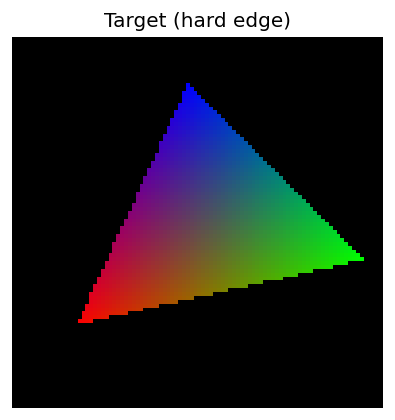

In [2]:
# Scene setup: a single RGB triangle on black background
H, W = 96, 96

# Target triangle vertices (NDC coords in [-1, 1])
verts_target = torch.tensor([
    [-0.65, -0.55],
    [ 0.90, -0.20],
    [-0.05,  0.75],
], dtype=torch.float32)

# Target vertex colors: red, green, blue
colors_target = torch.tensor([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
], dtype=torch.float32)

img_target = render_triangle_hard(H, W, verts_target, colors_target)
show_images([img_target], ["Target (hard edge)"])

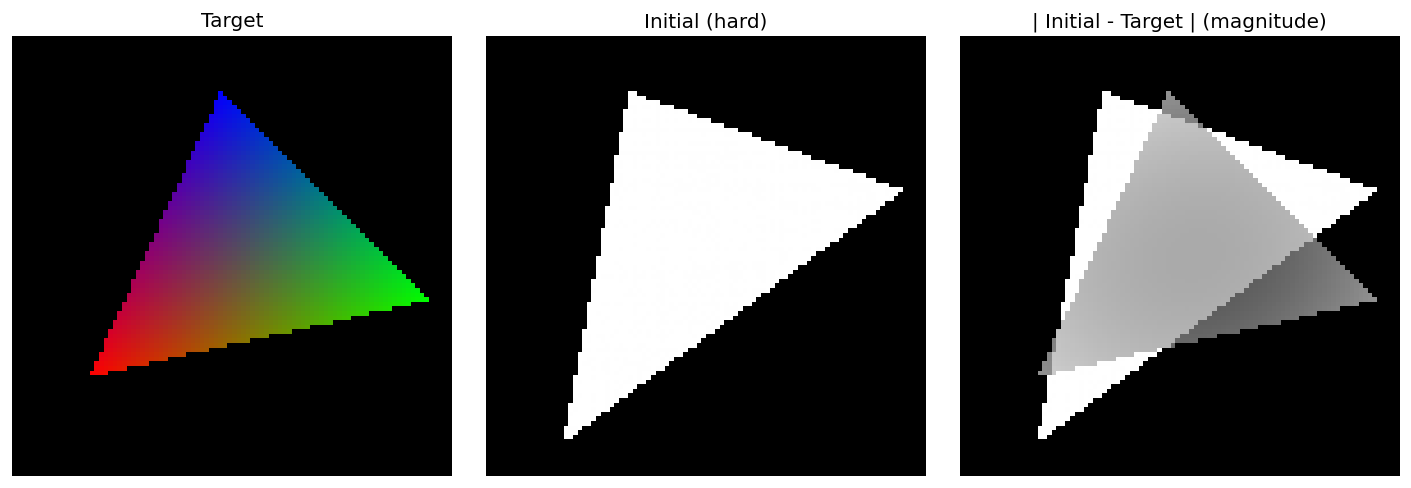

In [3]:
# Initial guess: slightly wrong geometry + all-white vertex colors
verts_init = torch.tensor([
    [-0.65, -0.85], # left
    [0.90, 0.30],   # right
    [-0.35,  0.75], # up
], dtype=torch.float32)
colors_init = torch.ones((3, 3), dtype=torch.float32)

img_init_hard = render_triangle_hard(H, W, verts_init, colors_init)
d_rgb, d_mag = diff_image(img_init_hard, img_target)
show_images(
    [img_target, img_init_hard, d_mag],
    ["Target", "Initial (hard)", "| Initial - Target | (magnitude)"],
    figsize=(12, 4)
 )

## Example 1 — Hard edge triangle (non-smooth)

**Problem**: Optimize scene parameters $\theta = (\mathbf{v}, \mathbf{c})$ where:
- $\mathbf{v} = [\mathbf{v}_0, \mathbf{v}_1, \mathbf{v}_2] \in \mathbb{R}^{3 \times 2}$ are vertex positions
- $\mathbf{c} = [\mathbf{c}_0, \mathbf{c}_1, \mathbf{c}_2] \in [0,1]^{3 \times 3}$ are vertex colors (RGB)

**Hard-edge renderer**: For each pixel $\mathbf{p}$:

$$\text{inside}(\mathbf{p}) = \begin{cases} 1 & \text{if } e_0(\mathbf{p}) \geq 0 \land e_1(\mathbf{p}) \geq 0 \land e_2(\mathbf{p}) \geq 0 \\ 0 & \text{otherwise} \end{cases}$$

where $e_i$ is the edge function (signed distance). The rendered color is:

$$\hat{I}(\mathbf{p}) = \begin{cases} w_0(\mathbf{p})\mathbf{c}_0 + w_1(\mathbf{p})\mathbf{c}_1 + w_2(\mathbf{p})\mathbf{c}_2 & \text{if inside} \\ \mathbf{0} & \text{otherwise} \end{cases}$$

**Optimization**: Adam optimizer with learning rate $\alpha = 0.001$:

$$\mathbf{v}_{t+1}, \mathbf{c}_{t+1} = \text{Adam}(\mathbf{v}_t, \mathbf{c}_t, \nabla_\theta \mathcal{L}_t, \alpha)$$

where $\mathcal{L} = \frac{1}{N}\sum_p \|\hat{I}(\mathbf{p}) - I^*(\mathbf{p})\|^2_2$

**Issue**: The hard step function $\text{inside}(\cdot)$ produces **zero or undefined gradients** at edge boundaries, causing optimization to stall or behave erratically.

Creating video with 202 frames...
Video saved to hard_edge_training.mp4


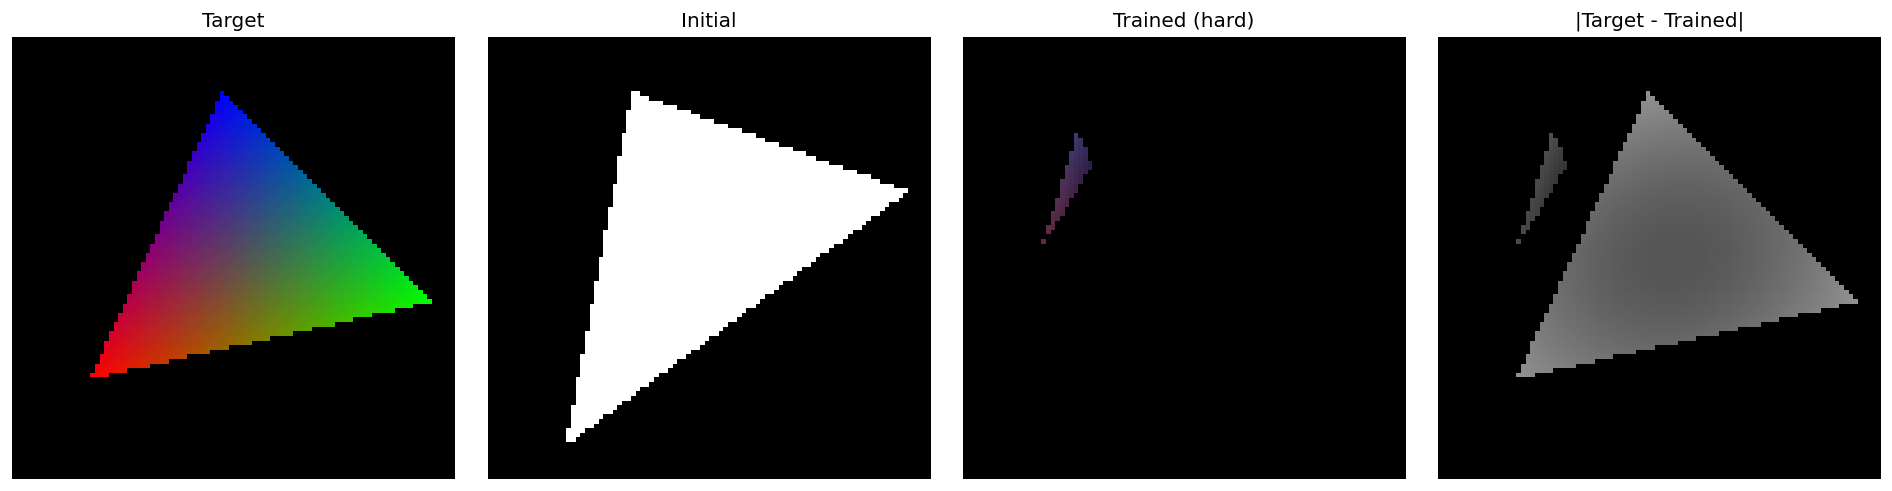

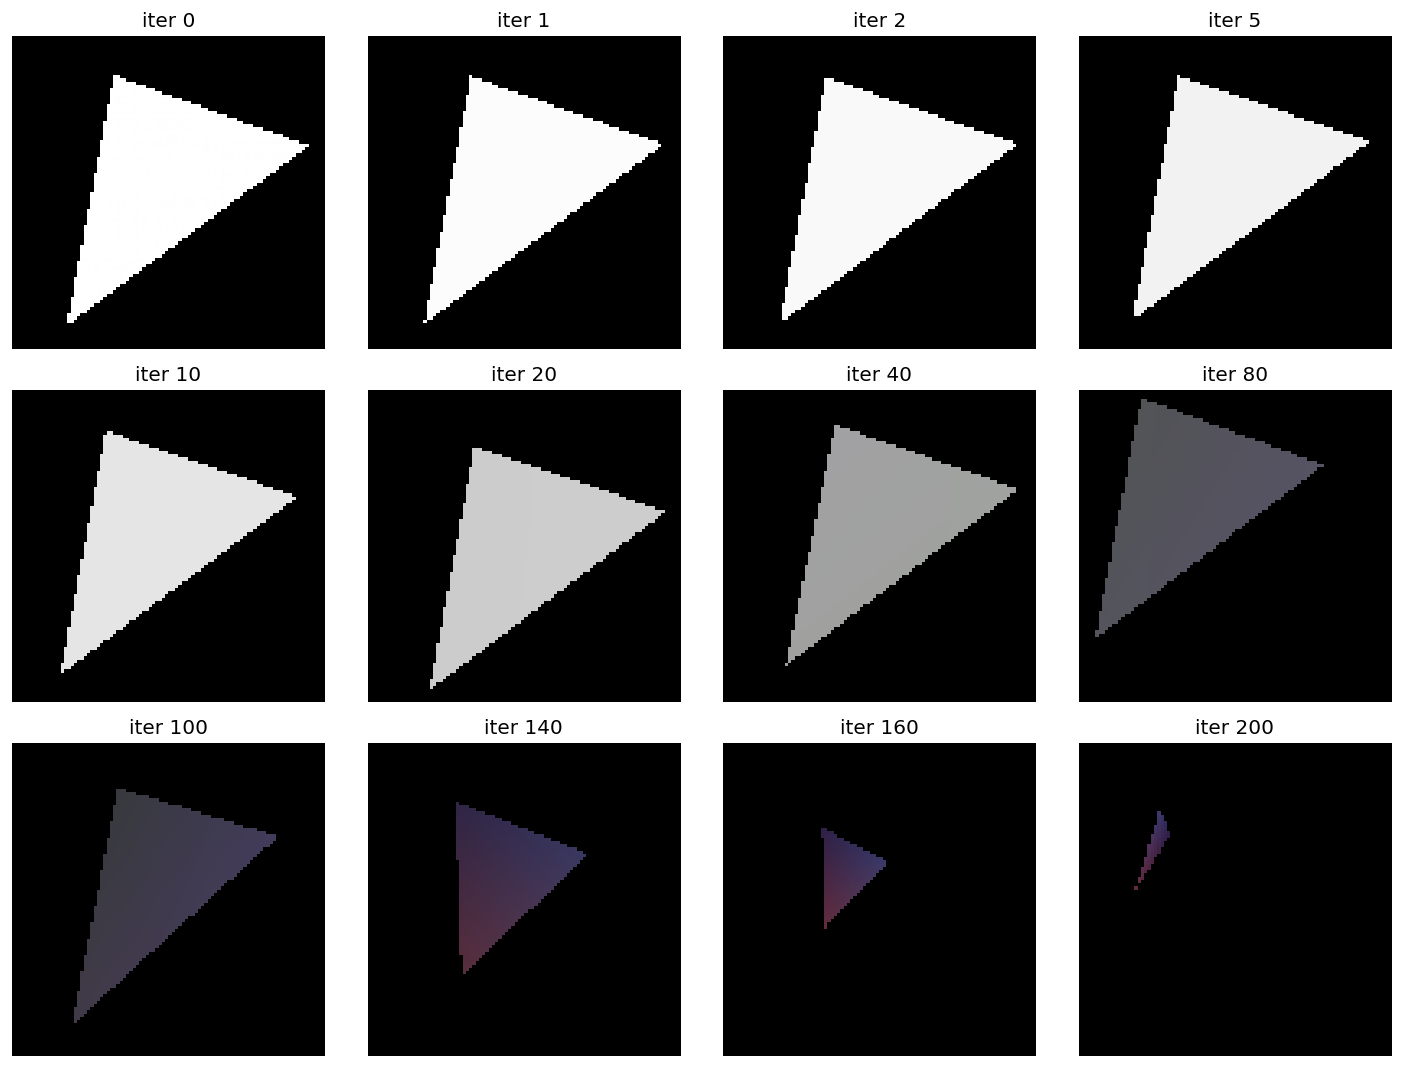

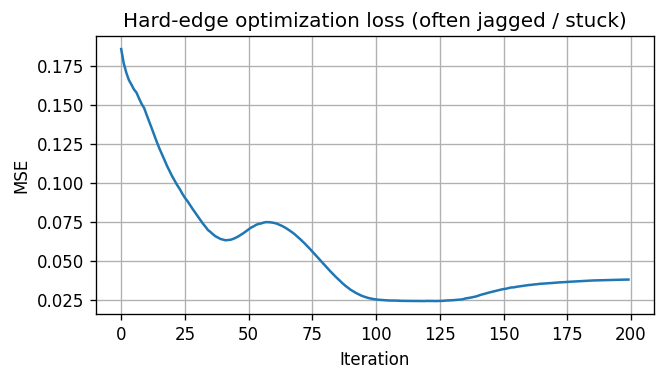

Hard-edge final loss: 0.03798447176814079
Hard-edge verts:
 [[-0.6422139   0.05266876]
 [-0.48386377  0.5722937 ]
 [-0.41566077  0.41645294]]
Hard-edge colors:
 [[0.40502074 0.16286579 0.24258232]
 [0.23024954 0.22229104 0.4326671 ]
 [0.17463389 0.11307205 0.27777353]]


In [4]:
# Optimization with PyTorch (hard-edge version)
# Create trainable parameters
verts_hard = verts_init.clone().detach().requires_grad_(True) # True/False 바꿔보세요
colors_hard = colors_init.clone().detach().requires_grad_(True)


# Use Adam optimizer for simpler, more stable training
optimizer_hard = torch.optim.Adam([verts_hard, colors_hard], lr=0.01)

history_hard = []
snapshots_hard = []  # list of (iter, verts, colors)
snapshot_schedule_hard = {0, 1, 2, 5, 10, 20, 40, 80, 100, 140, 160, 200}

# Video frames - capture every N iterations to keep video size reasonable
video_frames_hard = []
video_sample_rate = 1  # capture every 1 iterations

# Snapshot initial state
snapshots_hard.append((0, verts_hard.detach().clone(), colors_hard.detach().clone()))
# Add initial frame for video
initial_img = render_triangle_hard(H, W, verts_hard, colors_hard).detach().cpu().numpy()
video_frames_hard.append(initial_img)

max_iters_hard = 200
for it in range(max_iters_hard):
    optimizer_hard.zero_grad()
    
    # Clamp values to valid ranges (vertices and colors)
    with torch.no_grad():
        verts_hard.clamp_(-1.2, 1.2)
        colors_hard.clamp_(0.0, 1.0)
    
    # Render and compute loss
    img = render_triangle_hard(H, W, verts_hard, colors_hard)
    loss = torch.mean((img - img_target) ** 2)
    
    # Backward pass (NOTE: hard edges have zero/undefined gradients at discontinuities)
    loss.backward()
    optimizer_hard.step()
    
    # Record history
    history_hard.append(loss.item())
    
    # Take snapshots
    if (it + 1) in snapshot_schedule_hard:
        snapshots_hard.append((it + 1, verts_hard.detach().clone(), colors_hard.detach().clone()))
    
    # Capture video frames
    if (it + 1) % video_sample_rate == 0:
        frame = render_triangle_hard(H, W, verts_hard, colors_hard).detach().cpu().numpy()
        video_frames_hard.append(frame)

# Add final frame
final_frame = render_triangle_hard(H, W, verts_hard, colors_hard).detach().cpu().numpy()
video_frames_hard.append(final_frame)

# Save video
print(f"Creating video with {len(video_frames_hard)} frames...")
save_training_video(video_frames_hard, "hard_edge_training.mp4", fps=30, 
                   title="Hard-Edge Triangle Optimization")

# Display video
Video("hard_edge_training.mp4", embed=True, width=600)

# Final render
img_trained_hard = render_triangle_hard(H, W, verts_hard, colors_hard)

# Required: pixel-wise difference between target and trained
d_rgb_t, d_mag_t = diff_image(img_target, img_trained_hard)
show_images(
    [img_target, img_init_hard, img_trained_hard, d_mag_t],
    ["Target", "Initial", "Trained (hard)", "|Target - Trained|"],
    figsize=(16, 4)
 )

# Intermediate results during training (hard edges often jump / stall)
seen = set()
snapshots_hard_unique = []
for it, v, c in snapshots_hard:
    if it not in seen:
        snapshots_hard_unique.append((it, v, c))
        seen.add(it)
snapshots_hard_unique.sort(key=lambda t: t[0])

snap_imgs = []
snap_titles = []
for it, v, c in snapshots_hard_unique:
    snap_imgs.append(render_triangle_hard(H, W, v, c))
    snap_titles.append(f"iter {it}")
show_image_grid(snap_imgs, snap_titles, cols=4, cell_size=3.0)

plt.figure(figsize=(6, 3))
plt.plot(history_hard)
plt.title("Hard-edge optimization loss (often jagged / stuck)")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

print("Hard-edge final loss:", history_hard[-1])
print("Hard-edge verts:\n", verts_hard.detach().numpy())
print("Hard-edge colors:\n", colors_hard.detach().numpy())

## Example 2 — Soft edge triangle (hybrid approach with true distance)

**Problem**: Same optimization variables $\theta = (\mathbf{v}, \mathbf{c})$ as Example 1.

**Hybrid soft-edge renderer**: Uses a piecewise mask function that combines hard interior with Gaussian exterior based on **true Euclidean distance**:

$$\text{mask}(\mathbf{p}) = \begin{cases} 1.0 & \text{if } w_{\min} > 0 \text{ (inside)} \\ e^{-k \cdot d_{\min}^2} & \text{if } w_{\min} \leq 0 \text{ (outside)} \end{cases}$$

where:
- $w_{\min} = \min(w_0, w_1, w_2)$ (barycentric weights) determines **inside/outside**
- $d_{\min} = \min(d_{\text{edges}}, d_{\text{vertices}})$ is the **true Euclidean distance** (in pixel space) to the closest triangle feature
- $d_{\text{edges}} = \min\{d(\mathbf{p}, e_0), d(\mathbf{p}, e_1), d(\mathbf{p}, e_2)\}$ where $d(\mathbf{p}, e_i)$ is perpendicular distance to edge segment $i$
- $d_{\text{vertices}} = \min\{|\mathbf{p} - \mathbf{v}_0|, |\mathbf{p} - \mathbf{v}_1|, |\mathbf{p} - \mathbf{v}_2|\}$ is distance to nearest vertex
- $k$ controls the Gaussian decay rate outside (larger $k$ → faster decay)

The rendered color becomes:

$$\hat{I}(\mathbf{p}) = (1 - \text{mask}(\mathbf{p})) \cdot \mathbf{0} + \text{mask}(\mathbf{p}) \cdot (w_0\mathbf{c}_0 + w_1\mathbf{c}_1 + w_2\mathbf{c}_2)$$

**Key insights**: 
- A point is inside the triangle if **all** barycentric weights are positive ($w_0, w_1, w_2 > 0$)
- For points **outside**, we use **true Euclidean distance** to edges and vertices, not barycentric weights
- This provides mathematically correct distance-based falloff with proper handling of triangle corners

**Optimization**: Same Adam optimizer with $\alpha = 0.01$:

$$\mathbf{v}_{t+1}, \mathbf{c}_{t+1} = \text{Adam}(\mathbf{v}_t, \mathbf{c}_t, \nabla_\theta \mathcal{L}_t, \alpha)$$

In [ ]:
def render_triangle_soft(H, W, verts, colors, k=80.0, background=(0.0, 0.0, 0.0)):
    """Hybrid soft-edge triangle rasterizer with TRUE Euclidean distance falloff outside.
    
    Modified approach:
    - Inside triangle: render with full opacity (hard edge, mask = 1.0)
    - Outside triangle: Gaussian decay based on TRUE Euclidean distance to closest edge/vertex
    
    This creates sharp interior with smooth falloff outside, avoiding the
    "dark edge" problem while maintaining differentiability.
    
    k controls the Gaussian decay rate (larger k -> faster decay outside)
    """

    TODO: AI 사용을 권장합니다.
    
    # Blend with background using mask
    img = torch.zeros((H, W, 3), device=device, dtype=verts.dtype)
    img[...] = torch.tensor(background, device=device, dtype=verts.dtype)
    img = img * (1.0 - mask[..., None]) + rgb * mask[..., None]
    return img

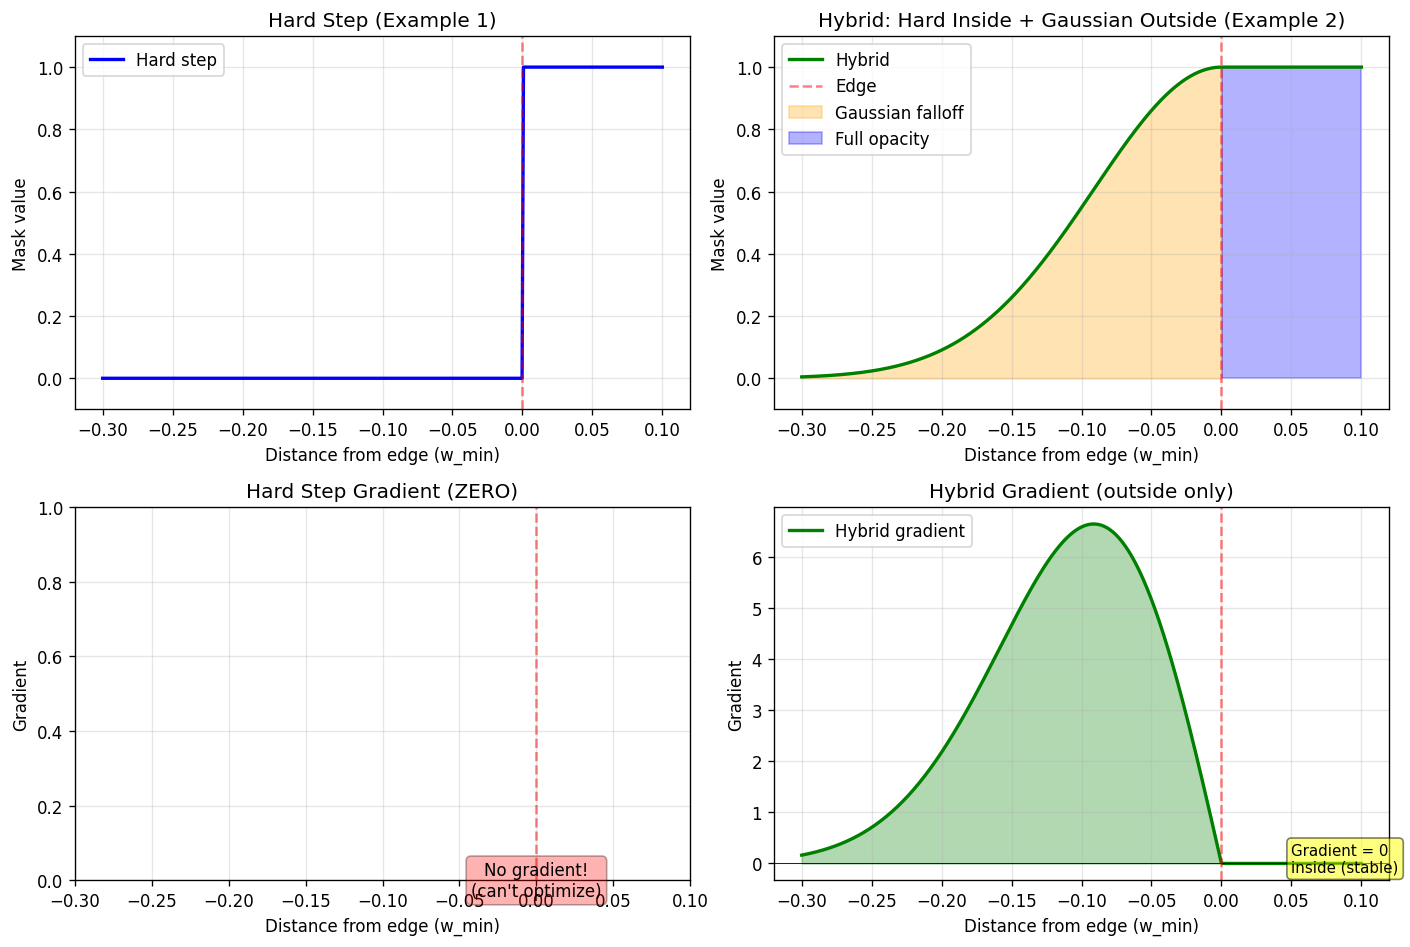

=== Hybrid Approach ===

Inside triangle (w_min > 0):
  • mask = 1.0 (full opacity)
  • gradient = 0 (stable, no 'dark edge' problem)

Outside triangle (w_min < 0):
  • mask = exp(-k × w_min²) (Gaussian decay)
  • gradient ≠ 0 (enables optimization)

Benefits:
  ✓ No dark edges (interior has full brightness)
  ✓ Still differentiable (Gaussian has smooth gradients)
  ✓ Creates soft 'glow' outside triangle
  ✓ Gradients only flow from outside region


In [6]:
# Visualization: How the hybrid render_triangle_soft() works
# Compare: Hard step vs Hybrid (hard inside + Gaussian outside)

# Define the soft edge parameter
k_soft = 60.0  # edge sharpness

# Visualize the mask function with extended range for better gradient visualization
x = np.linspace(-0.3, 0.1, 400)  # Extended range on the left (outside) for better gradient view
k = k_soft

# Hard step function (inside = 1, outside = 0)
step_vals = np.where(x >= 0, 1.0, 0.0)

# Hybrid function: hard inside + Gaussian outside
hybrid_vals = np.where(x >= 0, 1.0, np.exp(-k * x**2))

# Gradients
hybrid_grad = np.where(x >= 0, 0.0, -2 * k * x * np.exp(-k * x**2))

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Row 1: Mask functions
axes[0, 0].plot(x, step_vals, 'b-', linewidth=2, label='Hard step')
axes[0, 0].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[0, 0].set_xlabel('Distance from edge (w_min)')
axes[0, 0].set_ylabel('Mask value')
axes[0, 0].set_title('Hard Step (Example 1)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim([-0.1, 1.1])

axes[0, 1].plot(x, hybrid_vals, 'g-', linewidth=2, label='Hybrid')
axes[0, 1].axvline(0, color='red', linestyle='--', alpha=0.5, label='Edge')
axes[0, 1].fill_between(x[x < 0], 0, hybrid_vals[x < 0], alpha=0.3, color='orange', label='Gaussian falloff')
axes[0, 1].fill_between(x[x >= 0], 0, 1.0, alpha=0.3, color='blue', label='Full opacity')
axes[0, 1].set_xlabel('Distance from edge (w_min)')
axes[0, 1].set_ylabel('Mask value')
axes[0, 1].set_title('Hybrid: Hard Inside + Gaussian Outside (Example 2)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([-0.1, 1.1])

# Row 2: Gradients
axes[1, 0].axhline(0, color='black', linewidth=0.5)
axes[1, 0].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Distance from edge (w_min)')
axes[1, 0].set_ylabel('Gradient')
axes[1, 0].set_title('Hard Step Gradient (ZERO)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim(x.min(), x.max())
axes[1, 0].text(0, 0, 'No gradient!\n(can\'t optimize)', ha='center', va='center', 
               bbox=dict(boxstyle='round', facecolor='red', alpha=0.3), fontsize=10)

axes[1, 1].plot(x, hybrid_grad, 'g-', linewidth=2, label='Hybrid gradient')
axes[1, 1].axhline(0, color='black', linewidth=0.5)
axes[1, 1].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[1, 1].fill_between(x[x < 0], 0, hybrid_grad[x < 0], alpha=0.3, color='green')
axes[1, 1].set_xlabel('Distance from edge (w_min)')
axes[1, 1].set_ylabel('Gradient')
axes[1, 1].set_title('Hybrid Gradient (outside only)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].text(0.05, axes[1, 1].get_ylim()[0] * 0.5, 'Gradient = 0\ninside (stable)', 
               ha='left', fontsize=9, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.show()

print("=== Hybrid Approach ===")
print("\nInside triangle (w_min > 0):")
print("  • mask = 1.0 (full opacity)")
print("  • gradient = 0 (stable, no 'dark edge' problem)")
print("\nOutside triangle (w_min < 0):")
print("  • mask = exp(-k × w_min²) (Gaussian decay)")
print("  • gradient ≠ 0 (enables optimization)")
print("\nBenefits:")
print("  ✓ No dark edges (interior has full brightness)")
print("  ✓ Still differentiable (Gaussian has smooth gradients)")
print("  ✓ Creates soft 'glow' outside triangle")
print("  ✓ Gradients only flow from outside region")

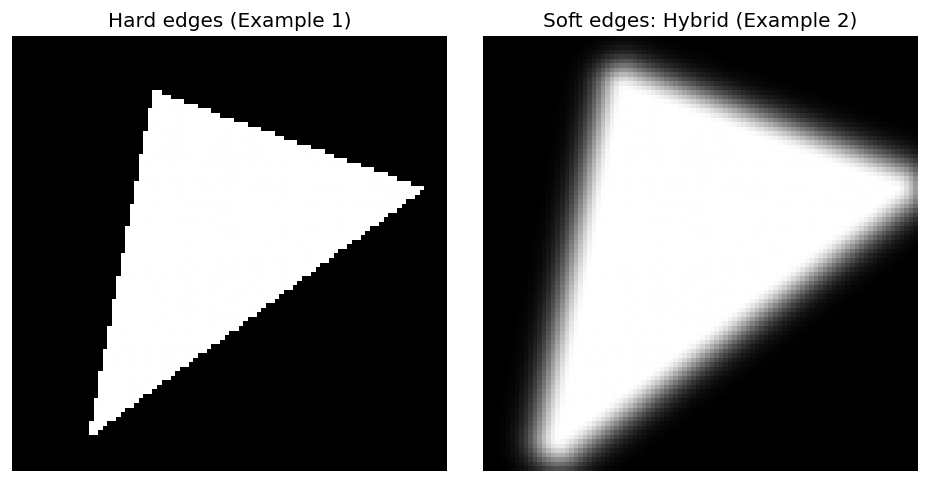


Notice:
• Interior: FULL brightness (no dark edges!)
• Exterior: Smooth Gaussian glow fading to black
• Edge: Continuous transition (differentiable)


In [7]:
# Show the new hybrid renderer on initial triangle
img_init_soft_hybrid = render_triangle_soft(H, W, verts_init, colors_init, k=k_soft)
img_init_hard = render_triangle_hard(H, W, verts_init, colors_init)

show_images(
    [img_init_hard, img_init_soft_hybrid],
    ["Hard edges (Example 1)", "Soft edges: Hybrid (Example 2)"],
    figsize=(8, 4)
)

print("\nNotice:")
print("• Interior: FULL brightness (no dark edges!)")
print("• Exterior: Smooth Gaussian glow fading to black")
print("• Edge: Continuous transition (differentiable)")

### Now let's run the full soft-edge optimization

With these visualizations in mind, you can see how the smooth gradients enable the optimizer to adjust both vertex positions and colors to match the target.

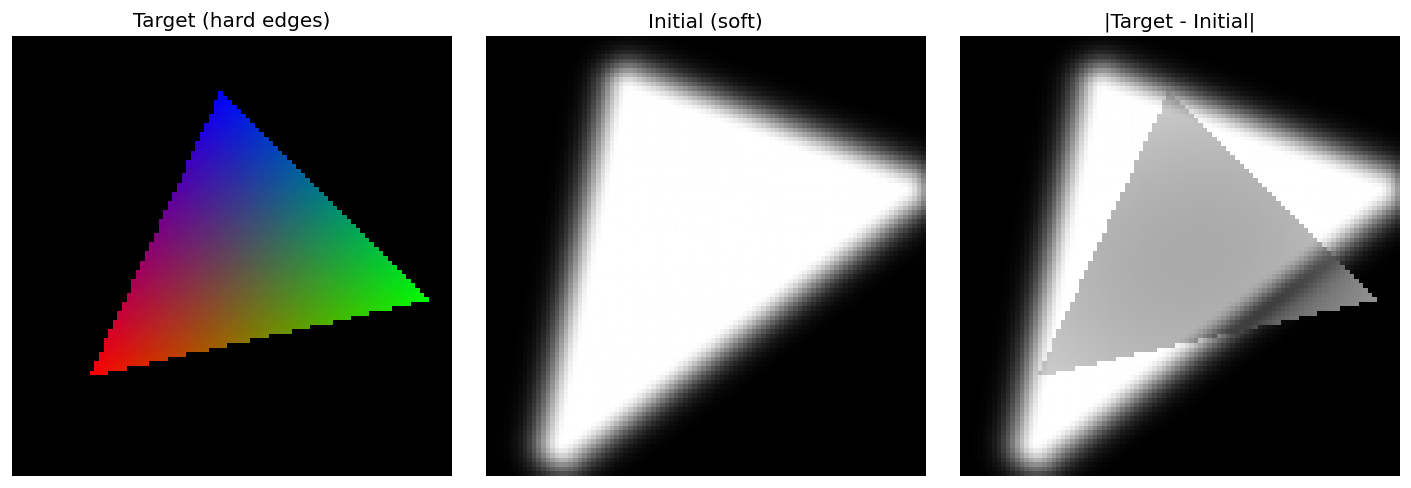

In [8]:
# Create target with HARD edges (ground truth)
img_target_soft = render_triangle_hard(H, W, verts_target, colors_target)
img_init_soft = render_triangle_soft(H, W, verts_init, colors_init, k=k_soft)

# Show initial state with difference visualization
d_rgb_init, d_mag_init = diff_image(img_target_soft, img_init_soft)
show_images(
    [img_target_soft, img_init_soft, d_mag_init],
    ["Target (hard edges)", "Initial (soft)", "|Target - Initial|"],
    figsize=(12, 4)
)

Creating video with 302 frames...
k_soft schedule: 10.0 → 10.0 (curriculum learning)
Video saved to soft_edge_training.mp4


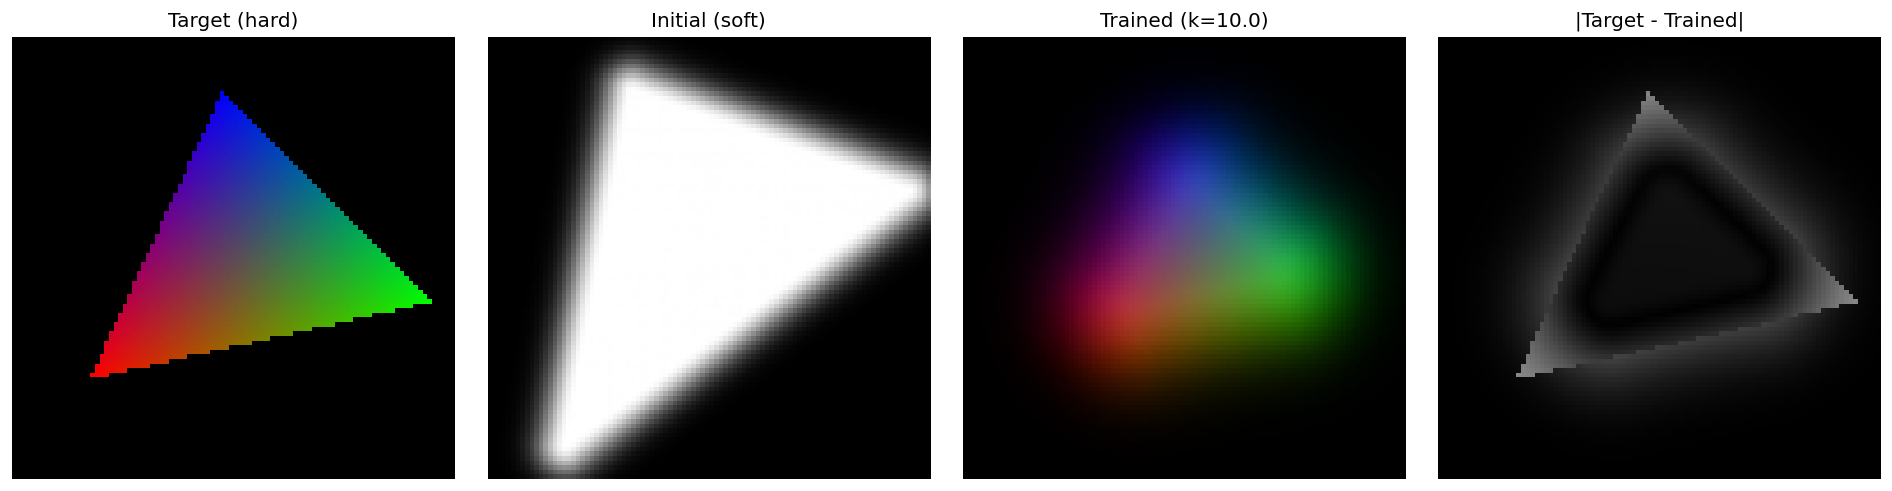

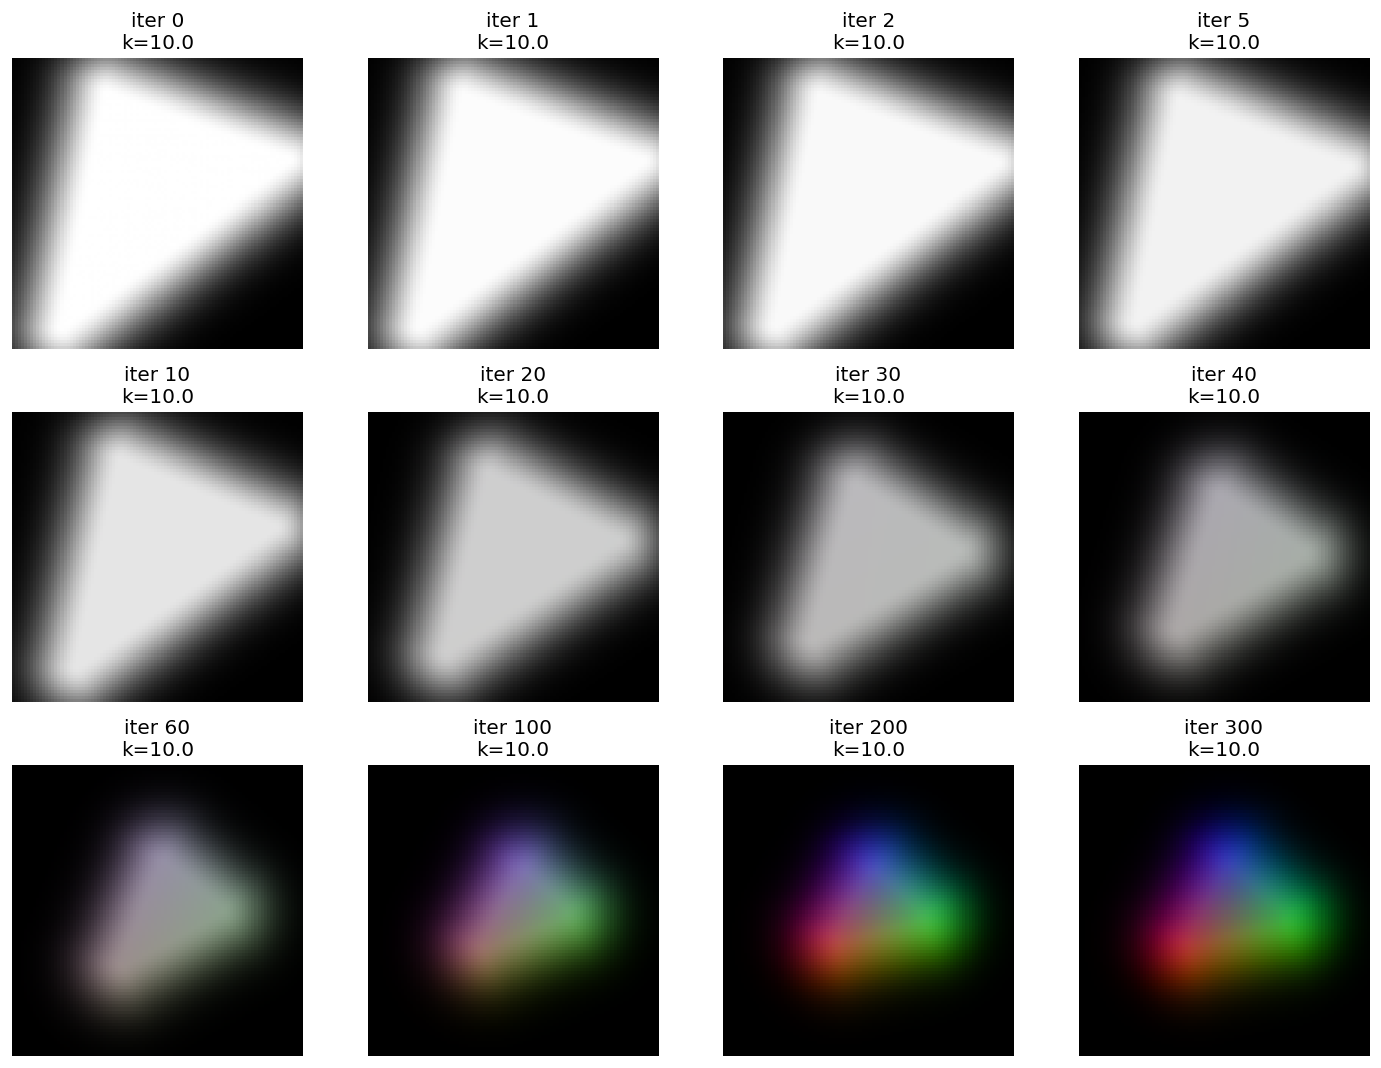

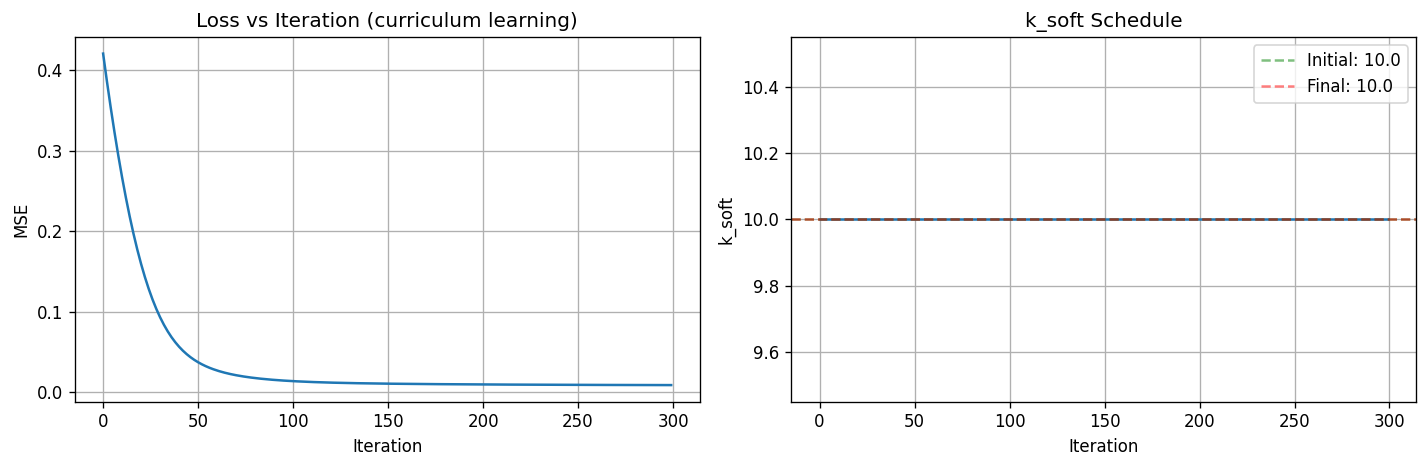


=== Curriculum Learning Results ===
Final loss (hard target): 0.008980
k_soft schedule: 10.0 → 10.0

Final vertices:
 [[-0.21890484 -0.1969904 ]
 [ 0.3850308  -0.05147349]
 [ 0.03704105  0.2681151 ]]

Final colors:
 [[0.6584663  0.22757927 0.2573897 ]
 [0.23109248 0.66129154 0.2734947 ]
 [0.2575778  0.28221735 0.6592651 ]]

Key benefit: Gradually increasing edge sharpness helps optimization
  - Start soft: easier gradients, faster initial convergence
  - End sharp: better match to hard-edge target


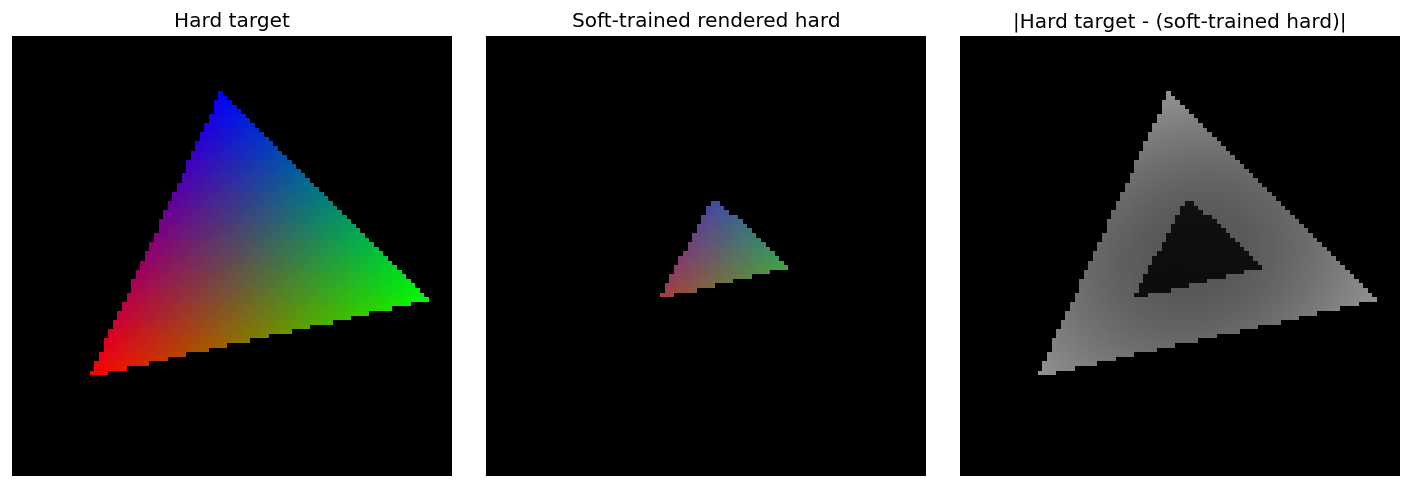

In [9]:
# Optimization with PyTorch (soft-edge version with curriculum learning)
# Create trainable parameters
verts_soft = verts_init.clone().detach().requires_grad_(True)
colors_soft = colors_init.clone().detach().requires_grad_(True)

# Use Adam optimizer
optimizer_soft = torch.optim.Adam([verts_soft, colors_soft], lr=0.01)

history_soft = []
snapshots_soft = []  # list of (iter, verts, colors, k_current)
snapshot_schedule_soft = {0, 1, 2, 5, 10, 20, 30, 40, 60, 100, 200, 300}

# Video frames - capture every N iterations
video_frames_soft = []
video_sample_rate = 1  # capture every 1 iterations

# Curriculum learning: start with soft edges, gradually make sharper
k_soft_initial = 10.0  # Start with very soft edges
k_soft_final = 10.0   # End with very sharp edges (nearly hard)

# Snapshot initial state
snapshots_soft.append((0, verts_soft.detach().clone(), colors_soft.detach().clone(), k_soft_initial))
# Add initial frame for video
initial_img = render_triangle_soft(H, W, verts_soft, colors_soft, k=k_soft_initial).detach().cpu().numpy()
video_frames_soft.append(initial_img)

max_iters_soft = 300
for it in range(max_iters_soft):
    optimizer_soft.zero_grad()
    
    # Gradually increase k_soft (curriculum learning)
    # Linear schedule: k increases from k_soft_initial to k_soft_final
    progress = it / max_iters_soft
    k_current = k_soft_initial + (k_soft_final - k_soft_initial) * progress
    
    # Clamp values to valid ranges
    with torch.no_grad():
        verts_soft.clamp_(-1.2, 1.2)
        colors_soft.clamp_(0.0, 1.0)
    
    # Render with current k and compute loss against HARD target
    img = render_triangle_soft(H, W, verts_soft, colors_soft, k=k_current)
    loss = torch.mean((img - img_target_soft) ** 2)
    
    # Backward pass (soft edges have smooth, well-defined gradients)
    loss.backward()
    optimizer_soft.step()
    
    # Record history
    history_soft.append(loss.item())
    
    # Take snapshots (save with current k)
    if (it + 1) in snapshot_schedule_soft:
        snapshots_soft.append((it + 1, verts_soft.detach().clone(), colors_soft.detach().clone(), k_current))
    
    # Capture video frames (use current k for rendering)
    if (it + 1) % video_sample_rate == 0:
        frame = render_triangle_soft(H, W, verts_soft, colors_soft, k=k_current).detach().cpu().numpy()
        video_frames_soft.append(frame)

# Add final frame (with final k)
final_k = k_soft_final
final_frame = render_triangle_soft(H, W, verts_soft, colors_soft, k=final_k).detach().cpu().numpy()
video_frames_soft.append(final_frame)

# Save video
print(f"Creating video with {len(video_frames_soft)} frames...")
print(f"k_soft schedule: {k_soft_initial:.1f} → {k_soft_final:.1f} (curriculum learning)")
save_training_video(video_frames_soft, "soft_edge_training.mp4", fps=30, 
                   title="Soft-Edge Triangle Optimization (Curriculum Learning)")

# Display video
Video("soft_edge_training.mp4", embed=True, width=600)

# Final render (with final sharp k)
img_trained_soft = render_triangle_soft(H, W, verts_soft, colors_soft, k=final_k)

# Required: pixel-wise difference between target and trained
d_rgb_t, d_mag_t = diff_image(img_target_soft, img_trained_soft)
show_images(
    [img_target_soft, img_init_soft, img_trained_soft, d_mag_t],
    ["Target (hard)", "Initial (soft)", f"Trained (k={final_k:.1f})", "|Target - Trained|"],
    figsize=(16, 4)
)

# Intermediate results during training (soft edges usually improve smoothly)
seen = set()
snapshots_soft_unique = []
for it, v, c, k_snap in snapshots_soft:
    if it not in seen:
        snapshots_soft_unique.append((it, v, c, k_snap))
        seen.add(it)
snapshots_soft_unique.sort(key=lambda t: t[0])

snap_imgs = []
snap_titles = []
for it, v, c, k_snap in snapshots_soft_unique:
    snap_imgs.append(render_triangle_soft(H, W, v, c, k=k_snap))
    snap_titles.append(f"iter {it}\nk={k_snap:.1f}")
show_image_grid(snap_imgs, snap_titles, cols=4, cell_size=3.0)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_soft)
plt.title("Loss vs Iteration (curriculum learning)")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.grid(True)

plt.subplot(1, 2, 2)
k_schedule = [k_soft_initial + (k_soft_final - k_soft_initial) * (i / max_iters_soft) for i in range(max_iters_soft)]
plt.plot(k_schedule)
plt.title("k_soft Schedule")
plt.xlabel("Iteration")
plt.ylabel("k_soft")
plt.grid(True)
plt.axhline(k_soft_initial, color='green', linestyle='--', alpha=0.5, label=f'Initial: {k_soft_initial}')
plt.axhline(k_soft_final, color='red', linestyle='--', alpha=0.5, label=f'Final: {k_soft_final}')
plt.legend()

plt.tight_layout()
plt.show()

print("\n=== Curriculum Learning Results ===")
print(f"Final loss (hard target): {history_soft[-1]:.6f}")
print(f"k_soft schedule: {k_soft_initial:.1f} → {k_soft_final:.1f}")
print("\nFinal vertices:\n", verts_soft.detach().numpy())
print("\nFinal colors:\n", colors_soft.detach().numpy())
print("\nKey benefit: Gradually increasing edge sharpness helps optimization")
print("  - Start soft: easier gradients, faster initial convergence")
print("  - End sharp: better match to hard-edge target")

# Also show how close the trained result is to the *hard* target (optional)
img_trained_soft_as_hard = render_triangle_hard(H, W, verts_soft, colors_soft)
d_rgb2, d_mag2 = diff_image(img_trained_soft_as_hard, img_target)
show_images([img_target, img_trained_soft_as_hard, d_mag2], ["Hard target", "Soft-trained rendered hard", "|Hard target - (soft-trained hard)|"], figsize=(12, 4))

## 참고자료

[Triangle Splatting for Real-Time Radiance Field Rendering](https://arxiv.org/pdf/2505.19175)

[Soft Rasterizer: A Differentiable Renderer for Image-based 3D Reasoning (2019)](https://arxiv.org/abs/1904.01786)